# Main trends in pregnancy data

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
import json
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import rfft,fft,fftfreq,rfftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit,brute,basinhopping
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
import math
from itertools import combinations
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from string import ascii_uppercase as abc; abc = abc
try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from itertools import compress, product
import random
from scipy.interpolate import InterpolatedUnivariateSpline as spline_interp
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patheffects as PathEffects
matplotlib_axes_logger.setLevel('ERROR')
np.seterr(divide='ignore', invalid='ignore')

def_color  = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

init_printing()
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=8) 
matplotlib.rcParams["figure.dpi"] = 100

# General functions

In [2]:
def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def remove_axe_labels(ax):
    ax.set_title('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
def to_dict(keys,values):
    return dict(zip(keys,values))

def get_test_dataframe(path,file):
    tdf       = pd.read_csv(path+file)
    tdf.index = np.array([np.array(s.replace('[','').replace(')','').split(',')).astype(int).mean() for s in tdf['week']])
    tdf       = tdf.drop(columns=['week'])
    tdf.rename(columns={"age50": "age"},inplace=True)
    
    if len(tdf)<140:
        missing_index = np.sort(list(set(np.arange(-59.5,80.5,1)) - set(tdf.index)))
        tdf = tdf.T
        [tdf.insert(int(np.argwhere(np.arange(-59.5,80.5,1) == missing_index[i])[0][0]),missing_index[i],np.nan) for i in range(len(missing_index))]
        tdf = tdf.T
    return tdf

wedgeprops = {'width':0.7,"edgecolor" : "k",'linewidth': 0.2,'antialiased': True}

# Loading the dataset
### Metadata infotmation
* 'metadata' - Tests names in various forms, divison to groups and units
* 'labnorm'  - Referenence values for tests

We consider only tests with reference values and remove tests with missing bins (86 tests)

In [3]:
# Loading the dataset into 'dfs'
path          = '../Clalit Data/pregnancy.1w/'
files         = [file for file in os.listdir(path)]
all_tests     = [file.split('.')[0] for file in files]
dfs           = dict(zip(all_tests,[get_test_dataframe(path,file) for file in files]))

# We removed duplicate tests
# Duplicate tests include K:POTASSIUM_BLOOD, Na:SODIUM_BLOOD, RDW:RDW_CV
remove        = ['POTASSIUM_BLOOD','SODIUM_BLOOD','RDW_CV']
all_tests     = np.unique(list(set(all_tests)- set(remove)))

groups        = ['Liver','Renal','Musculoskeletal','Metabolism','RBCs','Coagulation','Immune','Endocrine']
metadata      = pd.read_excel('../Files/Metadata.xlsx',index_col=0).drop(remove)
labnorm       = pd.read_csv('../Files/LabNorm.csv')

ndf           = pd.DataFrame([dfs[test]['n'] for test in all_tests],index=all_tests).fillna(0).astype(int)
labnorm_tests = list(metadata.loc[~metadata['LabNorm name'].isna()].index)
bias_df       = pd.read_csv('../Files/bias_score_070523.csv',index_col=0)
bias_tests    = set(bias_df.loc[bias_df.sum(axis=1)<3].index)
removed_tests = set(list(set(all_tests) - set(labnorm_tests)) + list(bias_tests))
tests         = sorted(list(set(labnorm_tests).intersection(all_tests) - set(removed_tests)))
len(tests)

In [4]:
def get_age_matched_reference(test):
    age  = int(np.nanmedian(dfs[test]['age']))
    tdf  = labnorm.loc[(labnorm.age==age)&(labnorm.lab==metadata.loc[test]['LabNorm name'])].fillna(method='ffill').fillna(method='bfill').copy()
    tdf['value'].loc[tdf.value<0] = np.min(tdf['value'].loc[tdf.value>0])
    prob = np.diff(tdf['quantile'])/np.sum(np.diff(tdf['quantile']))
    mu_  = (tdf.value.iloc[1:]*prob).sum()
    sd_  = np.sqrt((prob*((tdf.value.iloc[1:] - mu_)**2)).sum())
    q_to_val = interp1d(tdf['quantile'],tdf['value'])
    return {'quantile':q_to_val,'mean':mu_,'sd':sd_}

def get_value_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['mean']
    e   = tdf['sd']/np.sqrt(tdf['n'])
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_quantile_stats(test):
    tdf = dfs[test]
    n   = tdf['n']
    v   = tdf['qmean']
    e   = (tdf['qq75'] - tdf['qq25'])/(np.sqrt(tdf['n'])*0.675*2)
    return pd.DataFrame(np.array([n,v,e]).T,index=tdf.index,columns=['n','value','error'])

def get_value_at_quantile_stats(test):
    tdf = get_quantile_stats(test)
    if test in labnorm_tests:
        ref = get_age_matched_reference(test)
        v   = ref['quantile'](tdf['value'])
        e_p = ref['quantile'](tdf['value']+tdf['error'])
        e_m = ref['quantile'](tdf['value']-tdf['error'])
        e   = ((e_p - v) + (v-e_m))/2
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_SDS_stats(test):
    tdf      = get_value_stats(test)
    if test in labnorm_tests:
        ref      = get_age_matched_reference(test)
        ref_mean = ref['mean'] 
        ref_sd   = ref['sd']
        v        = (tdf['value'] - ref_mean) / ref_sd
        e        = tdf['error'] / ref_sd
        return pd.DataFrame(np.array([tdf['n'],v,e]).T,index=tdf.index,columns=['n','value','error'])
    else:
        return pd.DataFrame(index=tdf.index,columns=['n','value','error'])

def get_test_data(test):
    return {'mean'             :get_value_stats(test),
            'quantile'         :get_quantile_stats(test),
            'value_at_quantile':get_value_at_quantile_stats(test),
            'SDS'              :get_SDS_stats(test)}

def get_stats_from_dataset(test,stat,period=[-60,80],merge_timepoints = True):
    
    df       = data[test][stat].copy()
    df['sd'] = df['error']*np.sqrt(df['n'])
 
    split_k = 1
    if merge_timepoints:
        split_k  = np.min([int(np.ceil(np.nanmean((df['error']/(df['value'].std() * 0.15))**2))),7])
        
        if split_k > 1:
            df     = df.reset_index()
            splits = np.array_split(df, int(len(df)/split_k))
            x      = np.array([tdf['index'].mean()                                   for tdf in splits])
            n      = np.array([tdf['n'].sum()                                        for tdf in splits])
            v      = np.array([np.sum(tdf['value']*tdf['n'])/tdf['n'].sum()          for tdf in splits])
            sd     = np.array([np.sqrt(np.sum(tdf['sd']**2*tdf['n'])/tdf['n'].sum()) for tdf in splits])
            e      = sd/np.sqrt(n)
            df     = pd.DataFrame(np.array([n,v,e]).T,columns=['n','value','error'],index=x)
   
    df = df.loc[period[0]:period[1]]
    x  = df.index
    n  = df.n
    v  = df['value']
    e  = df['error']
    return x,v,e,n      

In [5]:
data = {test:get_test_data(test) for test in tqdm(tests)}

  0%|          | 0/78 [00:00<?, ?it/s]

## All tests show variation over pregnancy

In [6]:
res = []
for test in tests:
    x,v,e,n   = get_stats_from_dataset(test,'value_at_quantile',merge_timepoints=False)
    sd        = e*np.sqrt(n)
    imin,imax = v.argmin(),v.argmax()
    res.append(stats.ttest_ind_from_stats(v.iloc[imin],sd.iloc[imin],n.iloc[imin],v.iloc[imax],sd.iloc[imax],n.iloc[imax])[1])
pd.DataFrame(fdrcorrection(pd.DataFrame(res,index=tests)[0])[1])[0].sort_values().tail(10)

2     2.842469e-27
15    1.027716e-26
17    5.573734e-26
18    7.915726e-26
68    5.143340e-21
63    9.726248e-13
25    1.158924e-11
64    2.593691e-10
29    4.052529e-09
50    3.411385e-06
Name: 0, dtype: float64

In [7]:
summery = []
for test in tqdm(tests):
    temp           = get_test_data(test)
    ref            = get_age_matched_reference(test)
    
    x,v,e,n        = get_stats_from_dataset(test,'SDS',merge_timepoints=True)
    var_sds        = v.max() - v.min()
    
    x,v,e,n        = get_stats_from_dataset(test,'quantile',merge_timepoints=True)    
    var_q          = v.max() - v.min()
    
    x,v,e,n        = get_stats_from_dataset(test,'value_at_quantile',merge_timepoints=True)
    relative_range = 100*(v.max() - v.min())/ np.mean(v.iloc[:10])
    
    ref_cv         = 100*ref['sd']/ref['mean']
    summery.append([var_q,relative_range,ref_cv])
summery = pd.DataFrame(summery,columns=['quantile variation','percent change','reference CV'],index=tests)

  0%|          | 0/78 [00:00<?, ?it/s]

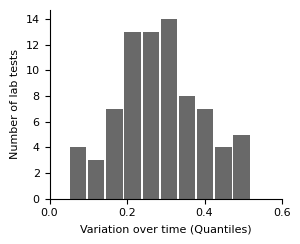

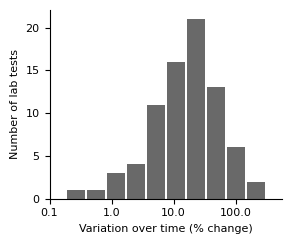

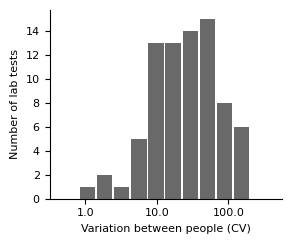

In [8]:
plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
summery['quantile variation'].hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Variation over time (Quantiles)')
ax.set_ylabel('Number of lab tests')
ax.set_xticks([0,0.2,0.4,0.6])

ax.grid(False)
remove_top_right_frame([ax])
plt.savefig('q_variation_hist.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
np.log10(summery['percent change']).hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Variation over time (% change)')
ax.set_ylabel('Number of lab tests')
ax.grid(False)
ax.set_xticks(np.arange(-1,4,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_xlim([-1,2.75])

remove_top_right_frame([ax])
plt.savefig('percent_variation_hist.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
np.log10(summery['reference CV']).hist(ax = ax,color='dimgray', zorder=2, rwidth=0.9)
ax.set_xlabel('Variation between people (CV)')
ax.set_ylabel('Number of lab tests')
ax.grid(False)
ax.set_xticks(np.arange(-1,4,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_xlim([-0.5,2.75])

remove_top_right_frame([ax])
plt.savefig('reference_variation_hist.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

## Homeostatic scaling

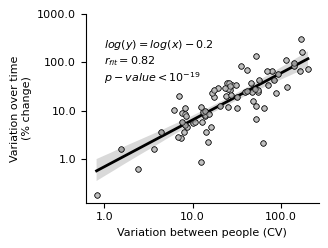

In [9]:
plt.figure(figsize=(3,2.5))
ax       = plt.subplot(111)
X,Y      = np.log10(summery.dropna()['reference CV']).values.reshape(-1, 1),np.log10(summery.dropna()['percent change']).values.reshape(-1, 1)
ax.scatter(X,Y,c='silver',s=15,edgecolor='k',lw=0.5)  
xlm,ylm  = ax.get_xlim(),ax.get_ylim()
xlm,ylm  = ax.get_xlim(),ax.get_ylim()

reg      = LinearRegression().fit(X,Y)
reg_line = [reg.coef_.flat[:]*xval +reg.intercept_.flat[:] for xval in np.arange(xlm[0],xlm[1],0.1)]
text     = '$log(y) = log(x) ' + str(np.round(reg.intercept_.flat[:][0],decimals=1)) + '$'
pearson_r   = np.round(stats.pearsonr(reg.predict(X).flat[:],Y.flat[:])[0],decimals=2)
pearson_pval= np.round(stats.pearsonr(reg.predict(X).flat[:],Y.flat[:])[1],decimals=5)

tdf = pd.DataFrame([np.log10(summery.dropna()['reference CV']),np.log10(summery.dropna()['percent change'])]).T
sns.regplot(ax=ax,x="reference CV", y="percent change", data=tdf,
            scatter_kws={"s": 15,"edgecolor":'k',"lw":0.5,"color":'silver'},
            line_kws={"color": "k","lw":2,"zorder":-5})

ax.annotate(text,(0,2.3))
ax.annotate('$r_{fit} = ' +str(pearson_r)+'$\n$p-value<10^{-19}$',(0,1.6))

# ax.plot(np.arange(xlm[0],xlm[1],0.1),reg_line,c='gray',zorder=-4,lw=2)
ax.set_xlim(xlm);ax.set_ylim(ylm)
ax.set_xlabel('Variation between people (CV)')
ax.set_ylabel('Variation over time\n(% change)')
ax.set_xticks(np.arange(0,3,1))
ax.set_xticklabels([str(float(10)**tick) for tick in ax.get_xticks()])
ax.set_yticks(np.arange(0,4,1))
ax.set_yticklabels([str(float(10)**tick) for tick in ax.get_yticks()])
remove_top_right_frame([ax])
plt.savefig('scatter_reference_precent.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);
plt.show()


## SI to Homeostatic scaling

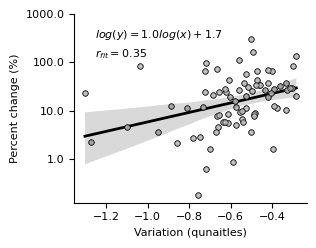

In [10]:
plt.figure(figsize=(3,2.5))
ax       = plt.subplot(111)
X,Y      = np.log10(summery.dropna()['quantile variation']).values.reshape(-1, 1),np.log10(summery.dropna()['percent change']).values.reshape(-1, 1)
ax.scatter(X,Y,c='silver',s=15,edgecolor='k',lw=0.5)  

xlm,ylm  = ax.get_xlim(),ax.get_ylim()
reg      = LinearRegression().fit(X,Y)
reg_line = [reg.coef_.flat[:]*xval +reg.intercept_.flat[:] for xval in np.arange(xlm[0],xlm[1],0.1)]
text     = '$log(y) = ' + str(np.round(reg.coef_.flat[:][0],decimals=1)) + 'log(x) + ' + str(np.round(reg.intercept_.flat[:][0],decimals=1)) + '$'
pearson_r= np.round(stats.pearsonr(reg.predict(X).flat[:],Y.flat[:])[0],decimals=2)
pearson_pval= np.round(stats.pearsonr(reg.predict(X).flat[:],Y.flat[:])[1],decimals=5)

tdf = pd.DataFrame([np.log10(summery.dropna()['quantile variation']),np.log10(summery.dropna()['percent change'])]).T
sns.regplot(ax=ax,x="quantile variation", y="percent change", data=tdf,
            scatter_kws={"s": 15,"edgecolor":'k',"lw":0.5,"color":'silver'},
            line_kws={"color": "k","lw":2,"zorder":-5})

ax.annotate(text,(xlm[0]+0.1,2.5))
ax.annotate('$r_{fit} = ' +str(pearson_r)+'$',(xlm[0]+0.1,2.1))

ax.set_xlim(xlm);ax.set_ylim(ylm)
ax.set_xlabel('Variation (qunaitles)')
ax.set_ylabel('Percent change (%)')
ax.set_yticks(np.arange(0,4,1))
ax.set_yticklabels([str(float(10)**tick) for tick in ax.get_yticks()])
remove_top_right_frame([ax])
plt.savefig('scatter_reference_quantile.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

## The trajectory over physiology space shows hysteresis

In [11]:
def annotate_point(week,projections,ax,label=[]):
    if not label:
        label= str(week)
    x_,y_ = projections.loc[week + 0.5].to_numpy()
    ax.text(x_,y_,label,alpha=0.99)
    ax.scatter(x_,y_,s=15,c='k')

def scale_weeks(weeks): ## define coloarmap
    temp           = weeks.copy()
    temp[temp < 0] = temp[temp < 0]/38
    temp[temp > 0] = temp[temp > 0]/80
    return temp

minima = -1
maxima = 1
norm   = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlBu_r)

tdf = pd.DataFrame([get_test_data(test)['quantile']['value']-0.5 for test in tests],index=tests).fillna(method ='backfill').T

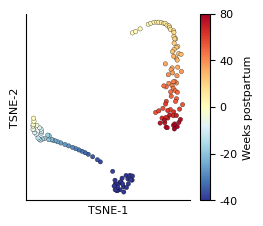

In [12]:
## get tsne projections
tsne        = TSNE(n_components=2, random_state=4)
projections = tsne.fit_transform(tdf)
projections = pd.DataFrame(projections,index=tdf.index)
pcolors     = scale_weeks(projections.index.to_numpy())

## plot
plt.figure(figsize=(3,2.5))
ax = plt.subplot(111)
scat = ax.scatter(projections[0],projections[1],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
# [annotate_point(t,projections,ax) for t in [-60,-35,-20,0,10,30,50,75]]
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.savefig('hyst_TSNE.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     
plt.show()

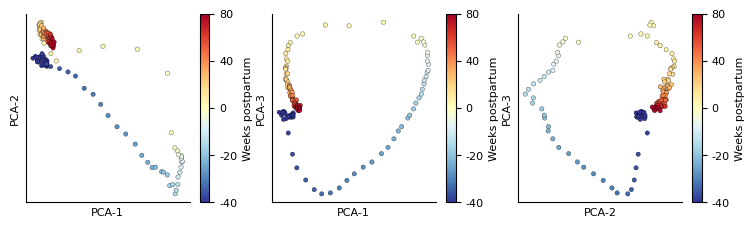

In [13]:
# get PCA projections
pca       = PCA(n_components=10).fit(tdf.T.to_numpy())
pc_scores = pd.DataFrame(pca.components_,columns=tdf.index).T
pcolors   = scale_weeks(pc_scores.index.to_numpy())

## plot
plt.figure(figsize=(3*3,2.5))
ax   = plt.subplot(131)
scat = ax.scatter(pc_scores[0],pc_scores[1],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
# [annotate_point(t,pc_scores[[0,1]],ax) for t in [-40,-26,-14,0,10,75]]
plt.xticks([])
plt.yticks([])


# ## plot
ax   = plt.subplot(132)
scat = ax.scatter(pc_scores[0],pc_scores[2],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-3')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
# [annotate_point(t,pc_scores[[0,2]],ax) for t in [-40,-26,-14,0,10,75]]
plt.xticks([])
plt.yticks([])


# ## plot
ax   = plt.subplot(133)
scat = ax.scatter(pc_scores[1],pc_scores[2],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PCA-2')
ax.set_ylabel('PCA-3')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
# [annotate_point(t,pc_scores[[1,2]],ax) for t in [-40,-26,-14,0,10,75]]
plt.xticks([])
plt.yticks([])

# plt.tight_layout() 
# plt.savefig('hyst_PCA.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     
plt.show()

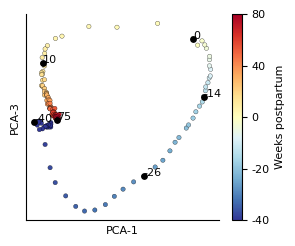

In [14]:
plt.figure(figsize=(3,2.5))

# ## plot
ax   = plt.subplot(111)
scat = ax.scatter(pc_scores[0],pc_scores[2],c=mapper.to_rgba(pcolors),s=10,edgecolor='k',lw=0.2)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-3')
remove_top_right_frame([ax])
cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum")
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.set_ticklabels([-40,-20,0,40,80])
[annotate_point(t,pc_scores[[0,2]],ax) for t in [-40,-26,-14,0,10,75]]
plt.xticks([])
plt.yticks([])

plt.tight_layout() 
plt.savefig('hyst_PCA.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     
plt.show()

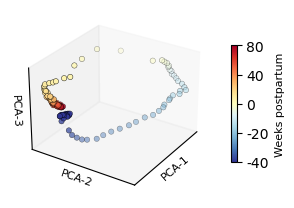

In [15]:
def annotate_point3d(week,projections,ax,label=[]):
    if not label:
        label= str(week)
    x_,y_,z_ = projections.loc[week + 0.5].to_numpy()
    ax.text(x_,y_,z_,label,alpha=0.99)
    ax.scatter(x_,y_,z_,s=15,c='k')

fig  = plt.figure(figsize=(3,2.5))
ax   = plt.axes(projection='3d')
scat = ax.scatter(pc_scores[0],pc_scores[1],pc_scores[2],c=mapper.to_rgba(pcolors),s=15,edgecolor='k',lw=0.3)
# [annotate_point3d(t,pc_scores[[0,1,2]],ax) for t in [-40,-26,-14,0,10,75]]

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('PCA-1',labelpad=-15)
ax.set_ylabel('PCA-2',labelpad=-15)
ax.set_zlabel('PCA-3',labelpad=-15)
ax.view_init(elev=28, azim=-147)

cbar = plt.colorbar(mapper,ax=ax,label="Weeks postpartum",ticks=[-1,-0.5,0,0.5,1],pad=0.1,fraction=0.025)
cbar.set_ticklabels([-40,-20,0,40,80],fontsize=10)
plt.savefig('hyst_PCA_3d.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     

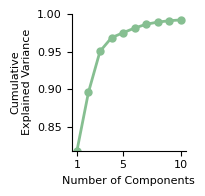

In [16]:
plt.figure(figsize=(2,2))
# ax = plt.subplot(131)
# ax.bar(np.arange(1,11),pca.explained_variance_ratio_,color='#86bf91', zorder=2, width=0.9)
# # ax.axhline(1/86,c='k')
# ax.set_xlabel('Number of Components')
# ax.set_ylabel('Explained Variance')
# remove_top_right_frame([ax])
# ax.set_yscale('log')
# ax.set_xticks([1,5,10])

ax = plt.subplot(111)
ax.plot(np.arange(1,11),np.cumsum(pca.explained_variance_ratio_),c='#86bf91',lw=2,marker='o',markersize=5)
ax.set_ylim([pca.explained_variance_ratio_[0],1])
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative\nExplained Variance')
ax.set_xticks([1,5,10])

remove_top_right_frame([ax])

plt.tight_layout()
plt.savefig('hyst_PCA_choose_n.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     
plt.show()

## Here we explore the main shapes of the tests during pregnancy and postpartum
### We developed a minimal model to explain the shape of these clusters

In [17]:
def get_pca_curve(test,preg_period,norm_baselines=True):
    # remove timepoints around delivery
    df       = get_test_data(test)['SDS'].drop(index=[-1.5,-0.5,0.5,1.5,2.5])
    df['sd'] = df['error']*np.sqrt(df['n'])

    ## norm end to start
    mu_end   = np.sum(df.loc[70:]['n']*df.loc[70:]['value'])/(np.sum(df.loc[70:]['n']))
    sd_end   = np.sqrt(np.sum(df.loc[70:]['n']*df.loc[70:]['sd']**2)/(np.sum(df.loc[70:]['n'])))
    mu_start = np.sum(df.loc[:-50]['n']*df.loc[:-50]['value'])/(np.sum(df.loc[:-50]['n']))
    sd_start = np.sqrt(np.sum(df.loc[:-50]['n']*df.loc[:-50]['sd']**2)/(np.sum(df.loc[:-50]['n'])))  

    mu          = pd.concat([(df['value'].loc[:0] - mu_start)/sd_start,(df['value'].loc[0:] - mu_end)/sd_end])
    err         = pd.concat([df['error'].loc[:0]/sd_start             ,df['error'].loc[0:]/sd_end])

    if norm_baselines:
        err.loc[0:] = err.loc[0:]/mu.loc[0:].std()
        err.loc[:0] = err.loc[:0]/mu.loc[:0].std()
        mu.loc[0:]  = mu.loc[0:]/mu.loc[0:].std()
        mu.loc[:0]  = mu.loc[:0]/mu.loc[:0].std()

    w_start, w_end = preg_period
    x   =  df.loc[w_start:w_end].index.values
    mu  =  mu.loc[w_start:w_end]
    err =  err.loc[w_start:w_end]
    return x,mu,err

The transformed data:

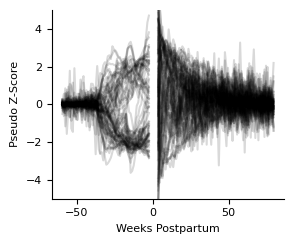

In [18]:
zdf = pd.DataFrame([get_pca_curve(test,[-60,80])[1] for test in tests],index=tests).T.fillna(method ='backfill')
plt.figure(figsize=(3,2.5))
ax  = plt.subplot(111)
zdf.loc[:0].plot(legend=False,c='k',alpha=0.15,ax=ax)
zdf.loc[0:].plot(legend=False,c='k',alpha=0.15,ax=ax)
ax.set_xlabel('Weeks Postpartum',fontsize=8)
ax.set_ylabel('Pseudo Z-Score',fontsize=8)
ax.set_ylim([-5,5])
remove_top_right_frame([ax])
plt.savefig('K_mean_normalization.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

I cluster the dataset using Kmeans, choosing number of cluster using the elbow method:

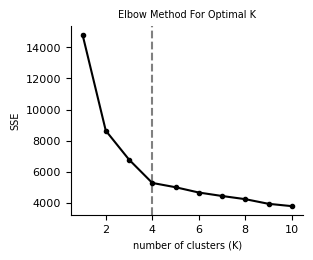

In [19]:
plt.figure(figsize=(3,2.5))
ax   = plt.subplot(111)
K    = range(1,11)
temp = np.array([KMeans(n_clusters=k).fit(zdf.to_numpy().T).inertia_ for k in K])
ax.plot(K, temp,c='k',marker='o',markersize=3)
ax.set_xlabel('number of clusters (K)',fontsize=7)
ax.set_ylabel('SSE',fontsize=7)
ax.set_title('Elbow Method For Optimal K',fontsize=7)
ax.axvline(x=4,c='gray',ls='--',zorder=-4)
ax.set_xlim([0.5,10.5])
remove_top_right_frame([ax])
plt.savefig('choose_K_cluster.pdf',bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

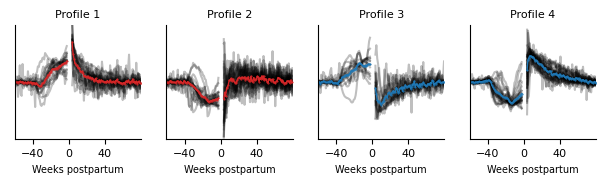

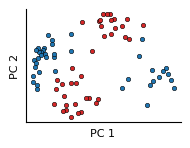

In [20]:
cluster_colors = [def_color[3],def_color[3],def_color[0],def_color[0]]

n_clusters= 4
kmeans    = KMeans(n_clusters,n_init =1000).fit(zdf.to_numpy().T)
clusters  = kmeans.fit_predict(zdf.to_numpy().T)
centroids = pd.DataFrame(np.squeeze(kmeans.cluster_centers_),columns=zdf.index).T

#order clusters
clust_dict        = to_dict(np.argsort(centroids.iloc[0]),centroids.columns.values)
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])

clust_dict        = {0:2,1:0,2:1,3:3}
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])

plt.figure(figsize=(7.5,1.5))
for i in range(n_clusters):
    ax = plt.subplot(1,4,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    centroids[i].loc[:0].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    centroids[i].loc[0:].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)

    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])
            
plt.subplots_adjust(wspace=0.2)
plt.savefig('clusters_PCA.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

plt.figure(figsize=(2,1.5))
ax        = plt.subplot(111)
pca       = PCA(n_components=2).fit(zdf.to_numpy())
pc_scores = pd.DataFrame(pca.components_,columns=zdf.columns).T
[pc_scores.loc[np.array(tests)[clusters == i]].plot.scatter(x=0,y=1,c=cluster_colors[i],ax=ax,s=10,edgecolor='k',linewidth=0.4) for i in range(4)]
ax.set_xticks([]); ax.set_xlabel('PC 1')
ax.set_yticks([]); ax.set_ylabel('PC 2')   
remove_top_right_frame([ax])  

plt.subplots_adjust(wspace=0.2)
plt.savefig('clusters_scatter_pca.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300); plt.show()
plt.show()

Using T-sne we get similar results with better seperation

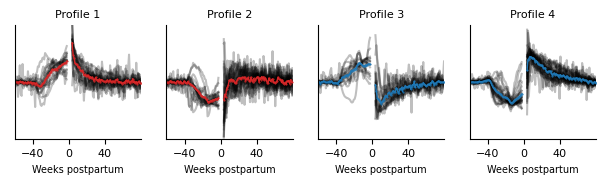

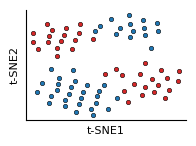

In [21]:
tsne        = TSNE(n_components=2, random_state=2)
projections = tsne.fit_transform(zdf.T)
projections = pd.DataFrame(projections,index=tests)

n_clusters  = 4
kmeans      = KMeans(n_clusters,n_init =1000).fit(projections)
clusters    = kmeans.fit_predict(projections)

centroids   = pd.DataFrame([zdf.T.loc[clusters==i].T.mean(axis=1) for i in range(4)]).T

#order clusters
clust_dict        = to_dict(np.argsort(centroids.iloc[0]),centroids.columns.values)
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])

clust_dict        = {0:1,1:0,2:2,3:3}
centroids.columns = [clust_dict[k] for k in centroids.columns]
clusters          = np.array([clust_dict[k] for k in clusters])

plt.figure(figsize=(7.5,1.5))
for i in range(n_clusters):
    ax = plt.subplot(1,4,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    zdf.T.loc[clusters==i].T.mean(axis=1).loc[:0].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    zdf.T.loc[clusters==i].T.mean(axis=1).loc[0:].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])

plt.subplots_adjust(wspace=0.2)
plt.savefig('clusters_TSNE.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()  

plt.figure(figsize=(2,1.5))
ax        = plt.subplot(111)
[projections.loc[np.array(tests)[clusters == i]].plot.scatter(x=0,y=1,c=cluster_colors[i],ax=ax,s=10,edgecolor='k',linewidth=0.4) for i in range(4)]
ax.set_xticks([]); ax.set_xlabel('t-SNE1')
ax.set_yticks([]); ax.set_ylabel('t-SNE2')   
remove_top_right_frame([ax])  

plt.tight_layout()
plt.savefig('clusters_scatter_TSNE.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

In [22]:
pd.DataFrame(clusters,index=tests)[0].to_csv('../Files/clusters_0705223.csv')

In [23]:
# plt.figure(figsize=(6,4))
# for i in range(len(groups)):
#     ax     = plt.subplot(2,4,i+1)
#     temp   = pd.DataFrame(clusters,index=tests).loc[set(tests).intersection(metadata.loc[metadata.Group == groups[i]].index)].sort_values(by=0)
#     colors = [cluster_colors[v] for v in temp[0].values]                         
#     sizes  = np.ones(len(temp)).astype(int)
#     labels = [metadata.loc[test]['Short name'] for test in list(temp.index)]
#     pie    = ax.pie(sizes, colors=colors,labels=labels,labeldistance=0.4,textprops=dict(color="k",size=7),rotatelabels =True,wedgeprops = wedgeprops)
#     ax.set_title(groups[i],fontsize=15,fontweight='bold')

# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)  
# plt.savefig('Clusters_enrichment.pdf',bbox_inches = 'tight',pad_inches=0.1);     
# plt.show()

# IFFL model for the clusters:

In [24]:
ax,bx,ay,by,t = symbols('a_x,b_x0,a_y,b_y0,t')

x       = Function('x')(t)
y       = Function('y')(t)
dx      = bx   - ax*x
dy      = by/x - ay*y
deqx    = Eq(Derivative(x),dx)
deqy    = Eq(Derivative(y),dy)
Matrix([deqx,deqy])

⎡ d                         ⎤
⎢ ──(x(t)) = -aₓ⋅x(t) + bₓ₀ ⎥
⎢ dt                        ⎥
⎢                           ⎥
⎢d                      b_y0⎥
⎢──(y(t)) = -a_y⋅y(t) + ────⎥
⎣dt                     x(t)⎦

We solve the model assuming $y$ dynamics are much faster than $x$. 

We solve the quasi steady state of $y$

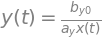

In [25]:
yqst = solve(dy,y)[0]
Eq(y,yqst)

The steady state of the model is thus:

In [26]:
xst = solve(dx,x)[0]
Eq(x,xst),Eq(y,yqst.subs(x,xst))

During pregnancy, there is a load on $x$ and $y$, modeled by increasing production rate

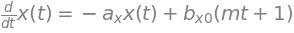

In [27]:
m    = symbols('m')
load = 1+m*t
deqx.subs(bx,bx*load)

The time-dependend solution for $x(t)$ is:

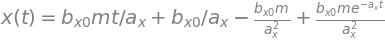

In [28]:
x_pregnancy = dsolve(deqx.subs(bx,bx*(1+m*t)),ics={x.subs(t,0):xst}).args[1]
Eq(x,x_pregnancy)

And thus for $y$ (assuming quasi steady state)

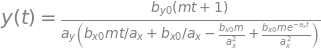

In [29]:
y_pregnancy = yqst.subs(by,by*(1+m*t)).subs(x,x_pregnancy)
Eq(y,y_pregnancy)

Following 38 weeks of gestation: the values of $x$ and $y$ at delivery ($x_d, y_d$)

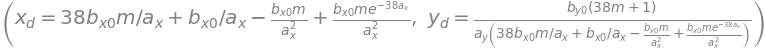

In [30]:
x_d = symbols('x_d')
y_d = symbols('y_d')
Eq(x_d,x_pregnancy.subs(t,38)),Eq(y_d,y_pregnancy.subs(t,38))

Postpartum, $x$ decay to its original steady state:

In [31]:
x_postpartum = dsolve(deqx,ics={x.subs(t,0):x_d}).args[1]
x_postpartum_full = x_postpartum.subs(x_d,x_pregnancy.subs(t,38))

Eq(x,x_postpartum)

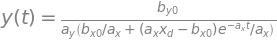

In [32]:
y_postpartum =yqst.subs(x,x_postpartum)
y_postpartum_full = y_postpartum.subs(x_d,y_pregnancy.subs(t,38))
Eq(y,y_postpartum)

In [33]:
pregnancy_func    = lambdify([t,ax,bx,ay,by,m],[x_pregnancy,y_pregnancy,load])
postpartum_func   = lambdify([t,ax,bx,ay,by,m],[x_postpartum_full,y_postpartum_full,1])
pregnancy_period  = np.arange(-22,38,1); pregnancy_period[pregnancy_period<0] = 0
postpartum_period = np.arange(0,80,1)

In [34]:
def IFFL_analytic_sol(pars):
    nx_preg,ny_preg,nload_preg = pregnancy_func(pregnancy_period,*pars)
    nx_pp,ny_pp,nload_pp       = postpartum_func(postpartum_period,*pars)
    numeric_x                  = np.append(nx_preg,nx_pp)
    numeric_y                  = np.append(ny_preg,ny_pp)
    numeric_load               = np.append(nload_preg,nload_pp)
    return numeric_x, numeric_y,numeric_load

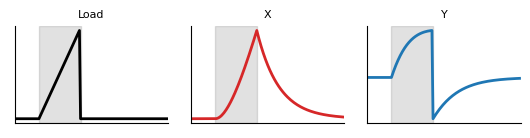

In [35]:
pars  = [0.05,0.05,1,1,0.01]
res   = pd.DataFrame(IFFL_analytic_sol(pars),columns=np.arange(-60,80),index=['x','y','load']).T.fillna(1)

plt.figure(figsize=(11*4/5,1.8*2))
ax1,ax2,ax3 = plt.subplot(241),plt.subplot(242),plt.subplot(243)

res.load.plot(ax=ax1,c='k',lw=2)
res.x.plot(ax=ax2,c=def_color[3],lw=2)
res.y.plot(ax=ax3,c=def_color[0],lw=2)

for ax in [ax1,ax2,ax3]:
    ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
    ax.set_yticks([])
    ax.set_xticks([])
    remove_top_right_frame([ax])

ax1.set_title('Load')
ax2.set_title('X')
ax3.set_title('Y')

plt.subplots_adjust(wspace=0.15,hspace=0.8)
plt.savefig('IFFL_model_scheme.pdf',bbox_inches = 'tight',pad_inches=0.1,dpi=300);     
plt.show()

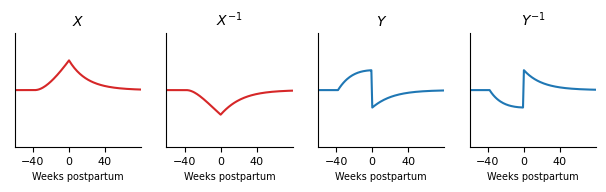

In [36]:
plt.figure(figsize=(7.5,1.5))
ax1,ax2,ax3,ax4 = plt.subplot(141),plt.subplot(142),plt.subplot(143),plt.subplot(144)

res['x']           .plot(ax=ax1,c=cluster_colors[0])              
(1/res['x'])       .plot(ax=ax2,c=cluster_colors[1])          
res['y']           .plot(ax=ax3,c=cluster_colors[2])              
(1/res['y'])       .plot(ax=ax4,c=cluster_colors[3])         

remove_top_right_frame([ax1,ax2,ax3,ax4])
[ax.set_yticks([]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlabel('Weeks postpartum',fontsize=7) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlim([-60,80]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xticks(np.arange(-40,80,40),fontsize=7) for ax in [ax1,ax2,ax3,ax4]]

ax1.set_ylim([1-0.4,1+0.4])
ax2.set_ylim([1-0.4,1+0.4])
ax3.set_ylim([1-0.4,1+0.4])
ax4.set_ylim([1-0.4,1+0.4])

ax1.set_title('$X$',fontsize=10)
ax2.set_title('$X^{-1}$',fontsize=10)
ax3.set_title('$Y$',fontsize=10)
ax4.set_title('$Y^{-1}$',fontsize=10)

plt.subplots_adjust(wspace=0.2)
plt.savefig('clusters_model.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

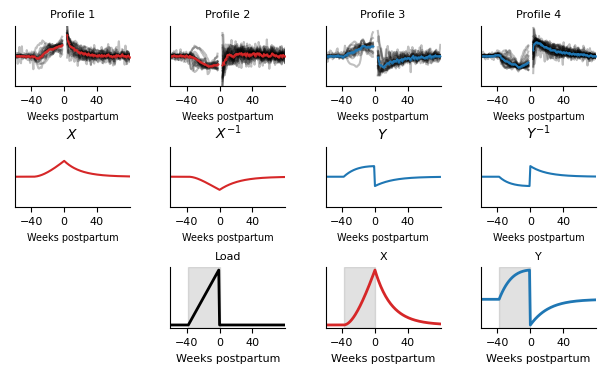

In [37]:
plt.figure(figsize=(7.5,4))
for i in range(n_clusters):
    ax = plt.subplot(3,4,i+1)

    zdf.T.loc[clusters==i].T.loc[:0].plot(legend=False,ax=ax,c='k',alpha=0.25)
    zdf.T.loc[clusters==i].T.loc[0:].plot(legend=False,ax=ax,c='k',alpha=0.25)

    zdf.T.loc[clusters==i].T.mean(axis=1).loc[:0].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    zdf.T.loc[clusters==i].T.mean(axis=1).loc[0:].plot(c=cluster_colors[i],ax=ax,title = 'Profile ' + str(i+1),marker='o',markersize=0.5,lw=1)
    ax.set_xlabel('Weeks postpartum',fontsize=7)
    ax.set_xlim([-60,80])
    ax.set_yticks([])
    ax.set_ylim([-6,6])
    ax.set_xticks(np.arange(-40,80,40),fontsize=7)
    ax.yaxis.set_tick_params(which='minor', bottom=False)
    remove_top_right_frame([ax])
    
ax1,ax2,ax3,ax4 = plt.subplot(345),plt.subplot(346),plt.subplot(347),plt.subplot(348)
res['x']           .plot(ax=ax1,c=cluster_colors[0])              
(1/res['x'])       .plot(ax=ax2,c=cluster_colors[1])          
res['y']           .plot(ax=ax3,c=cluster_colors[2])              
(1/res['y'])       .plot(ax=ax4,c=cluster_colors[3])         

remove_top_right_frame([ax1,ax2,ax3,ax4])
[ax.set_yticks([]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlabel('Weeks postpartum',fontsize=7) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlim([-60,80]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xticks(np.arange(-40,80,40),fontsize=7) for ax in [ax1,ax2,ax3,ax4]]

ax1.set_ylim([1-0.4,1+0.4])
ax2.set_ylim([1-0.4,1+0.4])
ax3.set_ylim([1-0.4,1+0.4])
ax4.set_ylim([1-0.4,1+0.4])

ax1.set_title('$X$',fontsize=10)
ax2.set_title('$X^{-1}$',fontsize=10)
ax3.set_title('$Y$',fontsize=10)
ax4.set_title('$Y^{-1}$',fontsize=10)

ax1,ax2,ax3 = plt.subplot(3,4,10),plt.subplot(3,4,11),plt.subplot(3,4,12)
res.load.plot(ax=ax1,c='k',lw=2)
res.x.plot(ax=ax2,c=def_color[3],lw=2)
res.y.plot(ax=ax3,c=def_color[0],lw=2)

for ax in [ax1,ax2,ax3]:
    ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
    ax.set_yticks([])
    ax.set_xticks([])
    remove_top_right_frame([ax])

ax1.set_title('Load')
ax2.set_title('X')
ax3.set_title('Y')
[ax.set_xticks(np.arange(-40,80,40)) for ax in [ax1,ax2,ax3]]
[ax.set_xlabel('Weeks postpartum') for ax in [ax1,ax2,ax3]]

plt.subplots_adjust(hspace=1,wspace=0.35)
plt.savefig('clusters_and_model.pdf',dpi=300,bbox_inches = 'tight',pad_inches=0.1); plt.show()
plt.show()

In [38]:
We numerically solve the model with equal turnover rate for X,Y

ax,bx,ay,by,t,m = symbols('a_x,b_x0,a_y,b_y0,t,m')
x       = Function('x')(t)
y       = Function('y')(t)
dx      = bx*(1+m)   - ax*x
dy      = by*(1+m)/x - ay*y
subs    = {ax:0.1,bx:0.1,ay:0.1,by:0.1}
xy_func= lambdify([x,y,m],Matrix([dx,dy]).subs(subs))

def sim_func(y,t):
    X,Y = y
    if t<22:
        m = 0
    if t>=22:
        m = 0.01*(t-22)
    if t>60:
        m = 0
    return xy_func(X,Y,m).flat[:]

sim_res = pd.DataFrame(odeint(sim_func,[1,1],np.arange(0,140,1)),columns=['x','y'],index=np.arange(-60,80))
sim_res['load'] = res['load']

plt.figure(figsize=(11*4/5,1.8*2))
ax1,ax2,ax3 = plt.subplot(241),plt.subplot(242),plt.subplot(243)

sim_res.load.plot(ax=ax1,c='k',lw=2)
sim_res.x.plot(ax=ax2,c=def_color[3],lw=2)
sim_res.y.plot(ax=ax3,c=def_color[0],lw=2)

for ax in [ax1,ax2,ax3]:
    ax.set_xlim([-60,80])
    ax.axvspan(-38,0,color='dimgray',alpha=0.2,zorder=-20)
    ax.set_yticks([])
    ax.set_xticks([])
    remove_top_right_frame([ax])

ax1.set_title('Load')
ax2.set_title('X')
ax3.set_title('Y')

plt.subplots_adjust(wspace=0.15,hspace=0.8)
plt.show()

plt.figure(figsize=(7.5,1.5))
ax1,ax2,ax3,ax4 = plt.subplot(141),plt.subplot(142),plt.subplot(143),plt.subplot(144)

sim_res['x']           .plot(ax=ax1,c=cluster_colors[0])              
(1/sim_res['x'])       .plot(ax=ax2,c=cluster_colors[1])          
sim_res['y']           .plot(ax=ax3,c=cluster_colors[2])              
(1/sim_res['y'])       .plot(ax=ax4,c=cluster_colors[3])         

remove_top_right_frame([ax1,ax2,ax3,ax4])
[ax.set_yticks([]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlabel('Weeks postpartum',fontsize=7) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xlim([-60,80]) for ax in [ax1,ax2,ax3,ax4]]
[ax.set_xticks(np.arange(-40,80,40),fontsize=7) for ax in [ax1,ax2,ax3,ax4]]

ax1.set_ylim([1-0.4,1+0.4])
ax2.set_ylim([1-0.4,1+0.4])
ax3.set_ylim([1-0.4,1+0.4])
ax4.set_ylim([1-0.4,1+0.4])

ax1.set_title('$X$',fontsize=10)
ax2.set_title('$X^{-1}$',fontsize=10)
ax3.set_title('$Y$',fontsize=10)
ax4.set_title('$Y^{-1}$',fontsize=10)

plt.subplots_adjust(wspace=0.2)
plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_2696/4158384503.py, line 1)